# DH-Parametertabelle youBot

$\begin{array}{rr} \hline
\mathbf{Gelenk} &\mathbf{\theta} &\mathbf{d} &\mathbf{a} &\mathbf{\alpha} \\ \hline
\mathbf{1} &0        &0.075 &0.033 &-\pi / 2 \\ \hline
\mathbf{2} &-\pi / 2 &0     &0.155 &0 \\ \hline
\mathbf{3} &0        &0     &0.135 &0 \\ \hline
\mathbf{4} &\pi / 2  &0     &0     &\pi / 2 \\ \hline
\mathbf{5} &\pi / 2  &0.218 &0     &0 \\ \hline
\end{array}$

DH Parameter

In [4]:
import sympy as sp
import numpy as np

dh_theta_values = np.array([0, -np.pi / 2, 0, np.pi / 2, np.pi / 2])
dh_alpha_values = np.array([-np.pi / 2, 0, 0, np.pi / 2, 0])
dh_a_values = np.array([0.033, 0.155, 0.135, 0, 0])
dh_d_values = np.array([0.075, 0, 0, 0, 0.218])

Wir programmieren nun eine Python-Funktion <b>dhIthFrame</b> zur Erstellung eines einzelnen DH-Frames. Dabei übergeben wir noch keine Parameter, sondern bleiben gänzlich auf symbolischer Ebene mit $\theta$, $d$, $a$ und $\alpha$.

In [5]:
def dhIthFrame(theta, d, a, alpha):
    
    rot_theta = np.matrix([ [np.cos(theta), -np.sin(theta), 0, 0], 
                            [np.sin(theta), np.cos(theta), 0, 0], [0, 0, 1, 0], 
                            [0, 0, 0, 1] ])
    
    trans_d = np.matrix([ [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d], [0, 0, 0, 1] ])
    trans_a = np.matrix([ [1, 0, 0, a], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1] ])
    
    rot_alpha = np.matrix([ [1, 0, 0, 0], 
                            [0, np.cos(alpha), -np.sin(alpha), 0], 
                            [0, np.sin(alpha), np.cos(alpha), 0], [0, 0, 0, 1] ])
    
    dh_ith_frame = rot_theta * trans_d * trans_a * rot_alpha
    
    return dh_ith_frame;

Dieses DH-Frame ist unsere Blaupause für die Forwärtstransformation am youBot. Wir definieren eine Python-Funktion <b>buildDhTcpFrame</b>, in welcher wir die Argumente eines solchen Blaupause-Frames durch die DH-Parameter und den Symbolen für die Gelenkwinkel $q_{1}$ bis $q_{5}$ iterativ substituieren und die resultierenden Frames zu einem Ergebnis-Frame akkumulieren. Anschließend vereinfachen wir noch das Ergebnis mit <b>trigsimp</b>.

In [6]:
def buildDhTcpFrame(q_array):
    dh_frame = np.identity(4)
      
    for i in range(5):
        tmp_dh_ith = dhIthFrame(q_array[i] + dh_theta_values[i], 
                                dh_d_values[i], 
                                dh_a_values[i], 
                                dh_alpha_values[i])
        dh_frame = np.matmul(dh_frame, tmp_dh_ith)
    
    return dh_frame

In [41]:
def normalize(data):
    dmax = np.radians(165)
    dmin = np.radians(-168)

    for i, arr in enumerate(data):
        for j, value in enumerate(arr):
            data[i][j] = (2 * (value - dmin) / (dmax - dmin)) - 1

In [42]:
def denormalize(data):
    dmax = np.radians(165)
    dmin = np.radians(-168)
    
    for i, arr in enumerate(data):
        for j, value in enumerate(arr):
            data[i][j] = (((value + 1) * (dmax - dmin)) / 2) + dmin

Kuka YouBot Gelenkwinkelgrenzenin Grad [+/-]

In [22]:
def generate_data(iterations=5):
    #Maximale und minimale Werte (based on robo freedom tests) */
    a1 = [165, -168]
    a2 = [85, -64]
    a3 = [145, -141]
    a4 = [101, -101]
    a5 = [155, -161]
    joint_limits = [a1, a2, a3, a4, a5]
    pos_arr = []
    for i in range(iterations):
        degree_joint_pos = []
        for joint_range in joint_limits:
            joint_val = np.random.randint(joint_range[1], joint_range[0] + 1)
            degree_joint_pos.append(joint_val)
        degree_joint_pos = np.asarray(degree_joint_pos)
        radians = np.radians(degree_joint_pos)
#         radians = degree_joint_pos
        pos_arr.append(radians)
    
    positions = np.asarray(pos_arr)
    
    tcp = []
    for i in range(iterations):
        frame = buildDhTcpFrame(positions[i])
        frame = np.asarray(frame.flatten())
        frame = frame[0:, :12]
        frame = np.squeeze(frame)
#         xyz = frame[3::4]
        tcp.append(frame)

    tcp = np.asarray(tcp)

    return positions, tcp

In [23]:
j, t = generate_data(10)

Generiere eine Anzahl von zufälligen Gelenkwinkelpositionen und dazugehöriges TCP Frame

In [25]:
import time

start = time.time()

joint_pos, tcp_pos = generate_data(10)
# max_tcp = np.amax(np.absolute(tcp_positions))
# tcp_positions = tcp_positions / max_tcp
end = time.time()
print(end - start)

0.017319202423095703


In [26]:
print("TCP Length:", len(tcp_pos))
print("Joint Length:", len(joint_pos))
print("TCP Shape:", tcp_pos.shape)
print("Joint Shape:", joint_pos.shape)

TCP Length: 10
Joint Length: 10
TCP Shape: (10, 12)
Joint Shape: (10, 5)


<IPython.core.display.Javascript object>


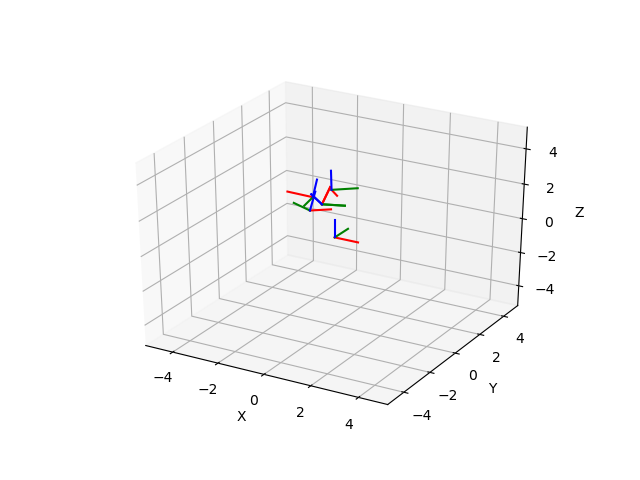

In [27]:
from mpl_toolkits import mplot3d
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import *
%matplotlib notebook

tcp = tcp_pos

ax = plot_basis(R=np.eye(3), ax_s=5)
f = 5
samples = np.random.randint(0, len(tcp), 5)
for i in samples:
    point = np.asarray([tcp[i][3] *f, tcp[i][7] *f, tcp[i][11] *f])
    rot = np.asarray([[tcp[i][0], tcp[i][1], tcp[i][2]],
                      [tcp[i][4], tcp[i][5], tcp[i][6]],
                      [tcp[i][8], tcp[i][9], tcp[i][10]]])
    plot_basis(ax, R=rot, p=point)

plt.show()


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
    
layer = Dense(units=100, 
          input_dim=12,
          kernel_initializer='random_normal',
          use_bias=True,
          bias_initializer='random_normal',
          activation='tanh')

model.add(layer)

for i in range(1):
    layer = Dense(units=100, 
                  kernel_initializer='random_normal',
                  use_bias=True,
                  bias_initializer='random_normal',
                  activation='tanh')
    model.add(layer)
    
layer = Dense(units=5, 
              kernel_initializer='random_normal',
              use_bias=True,
              bias_initializer='random_normal',
              activation='tanh')
model.add(layer)

Using TensorFlow backend.


In [29]:
from keras.optimizers import RMSprop
from keras.optimizers import Adam
# For a mean squared error regression problem
rms = RMSprop(learning_rate=0.01, rho=0.9)
adam=Adam(lr=1.0e-3)
model.compile(optimizer=adam,loss='mse')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1300      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________


In [43]:
import keras.utils as tf

def gen(batch_size):
    jpos, tcp = generate_data(batch_size)
    normalize(jpos)
    tpos = tf.normalize(tcp, axis=-1, order=2)
    return jpos, tpos, jnorm

In [33]:
jpos, tpos, _ = gen(10000)
# model.fit_generator(generator = gen(1000),
#                     validation_data = gen(500),
#                     steps_per_epoch = 100,
#                     epochs = 20,
#                     validation_steps = 3)

In [34]:
model.fit(tpos, jpos, epochs=100)

Epoch 1/100
10000/10000 [==============================] - 2s 244us/step - loss: 0.2112
Epoch 2/100
10000/10000 [==============================] - 1s 101us/step - loss: 0.2065
Epoch 3/100
10000/10000 [==============================] - 1s 107us/step - loss: 0.2059
Epoch 4/100
10000/10000 [==============================] - 1s 100us/step - loss: 0.2054
Epoch 5/100
10000/10000 [==============================] - 1s 102us/step - loss: 0.2055
Epoch 6/100
10000/10000 [==============================] - 1s 91us/step - loss: 0.2051
Epoch 7/100
10000/10000 [==============================] - 1s 95us/step - loss: 0.2053
Epoch 8/100
10000/10000 [==============================] - 1s 102us/step - loss: 0.2052
Epoch 9/100
10000/10000 [==============================] - 1s 96us/step - loss: 0.2052
Epoch 10/100
10000/10000 [==============================] - 1s 92us/step - loss: 0.2051
Epoch 11/100
10000/10000 [==============================] - 1s 89us/step - loss: 0.2052
Epoch 12/100
10000/10000 [=========

10000/10000 [==============================] - 1s 91us/step - loss: 0.1794
Epoch 94/100
10000/10000 [==============================] - 1s 109us/step - loss: 0.1794
Epoch 95/100
10000/10000 [==============================] - 1s 87us/step - loss: 0.1786
Epoch 96/100
10000/10000 [==============================] - 1s 97us/step - loss: 0.1789
Epoch 97/100
10000/10000 [==============================] - 1s 85us/step - loss: 0.1787
Epoch 98/100
10000/10000 [==============================] - 1s 91us/step - loss: 0.1786
Epoch 99/100
10000/10000 [==============================] - 1s 100us/step - loss: 0.1785
Epoch 100/100
10000/10000 [==============================] - 1s 97us/step - loss: 0.1783


In [35]:
class Drawer():      
    def __init__(self):
        '''variable definitions'''
        self.z = np.empty(5,dtype=float) #vertical coordinate
        self.x = np.empty(5,dtype=float) #x axis components 
        self.y = np.empty(5,dtype=float) #y axis components
  
        self.fig = plt.figure("Robot Simulator")
        self.ax = plt.axes([0.05, 0.2, 0.90, .75], projection='3d')

    def set_positions(self):#gets the x,y,z values
        xs = self.x.tolist()
        ys = self.y.tolist()
        zs = self.z.tolist()
        self.ax.cla()
        self.ax.plot(xs, ys, zs, 'o-', markersize=10, 
                     markerfacecolor="black", linewidth = 6, color="orange")
        
    def set_ax(self):#ax panel set up
        self.ax.set_xlim3d(-400, 400)
        self.ax.set_ylim3d(-400, 400)
        self.ax.set_zlim3d(-400, 400)
        self.ax.set_xlabel('X axis')
        self.ax.set_ylabel('Y axis')
        self.ax.set_zlabel('Z axis')
        
    def calc_x_y_z(self, q_array):#calc x_y_z coordinates
        dh_frame = np.identity(4)
        for i in range(5):
            tmp_dh_ith = dhIthFrame(q_array[i] + dh_theta_values[i], 
                                    dh_d_values[i], 
                                    dh_a_values[i], 
                                    dh_alpha_values[i])
            dh_frame = np.matmul(dh_frame, tmp_dh_ith)
            xyz = dh_frame[:-1, -1]
            self.x[i] = xyz[0] * 1000
            self.y[i] = xyz[1] * 1000
            self.z[i] = xyz[2] * 1000
            
    def draw_robot(self, q_array):
        self.calc_x_y_z(q_array)
        self.set_positions()
        self.set_ax()

        plt.draw()


In [36]:
%matplotlib notebook
pred_pos, pred_tcp, jnorm = gen(20)
pred_tcp = tf.normalize(pred_tcp, axis=-1, order=2)
# print(pred_pos)
# print(out)
out = model.predict(tpos)
pred_pos = np.copy(jpos)
denormalize(pred_pos, _)
denormalize(out, _)
for i in range(10):
    print(pred_pos[i])
    print(out[i])

[-0.59341195  1.18682389 -0.2443461  -1.13446401  1.44862328]
[0.09797987 0.509713   0.2216022  0.00377522 1.1951715 ]
[ 2.49582083 -0.19198622 -0.38397244 -0.43633231 -2.44346095]
[ 0.16380548 -0.0206718   0.17519201  0.14831538 -0.5864972 ]
[ 1.6406095   1.29154365  1.06465084  1.37881011 -1.09955743]
[2.0496826  1.5392329  1.4385281  0.07581738 0.12262746]
[-2.8099801  -0.40142573  0.03490659  1.13446401  1.85004901]
[-0.09650014  0.24234721  0.01610288 -0.14278279 -0.32234725]
[ 1.46607657  1.25663706  0.9424778  -0.2268928  -0.15707963]
[ 1.4547586   1.1864882   1.4880217   0.14897168 -0.34719515]
[-0.27925268  0.50614548  1.51843645  1.18682389  2.04203522]
[0.427777   0.43688574 0.70664185 0.24879998 1.4216515 ]
[-0.78539816 -0.2443461  -1.53588974  1.32645023  0.31415927]
[ 0.26036185 -0.07903132 -0.18465045 -0.0462717  -0.46474913]
[-0.34906585  0.2268928   1.30899694  0.06981317  0.83775804]
[0.06408978 0.56306213 0.7311891  0.17352143 0.04455803]
[-0.13962634 -0.68067841  1.

<IPython.core.display.Javascript object>


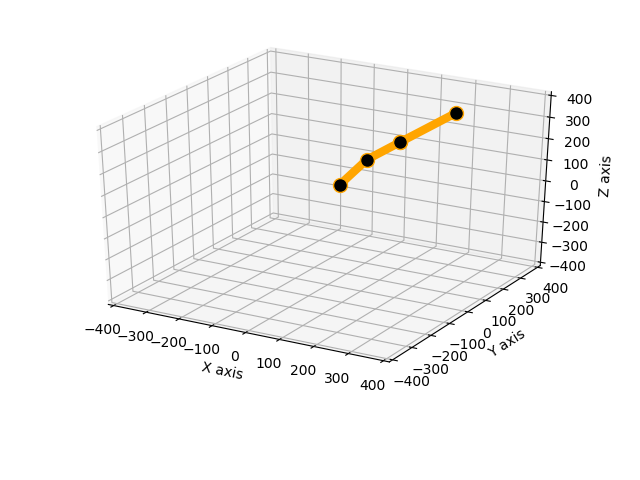

In [39]:
%matplotlib notebook
drawer = Drawer()

drawer.draw_robot(out[0])

<IPython.core.display.Javascript object>


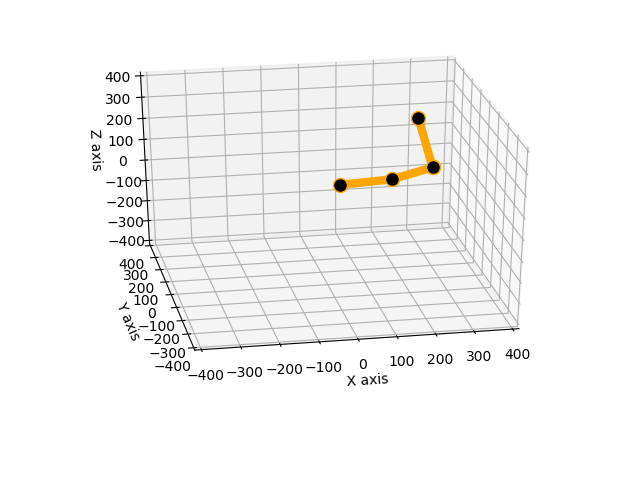

In [40]:
%matplotlib notebook
drawer2 = Drawer()
drawer2.draw_robot(pred_pos[0])

In [225]:
print(pred_pos)
print(tmp)

[[-1.06465084  0.4712389   0.78539816 -1.25663706  0.34906585]]
[[-1.06465084  0.4712389   0.78539816 -1.25663706  0.34906585]]
